# A Covolutional Neural Network

We will be building a Convolutional Neural Network that could classify images as Cats and Dogs.

In [2]:
train_dataset_dir_path = r"C:\Local Disk\Programming\Python Projects\keras complete\dogs-vs-cats\Processed"

In [3]:
# Imoting necessary libraries

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline 

# appear and be store within a notebook ( For %matplotlib inline )

In [4]:
# To check and enable Tensorflow GPU - If running a GPU, run this cell

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Availabel : ',len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num GPUs Availabel :  1


# Data Preparation

We are gonna process the data-set and break it into train, val and test set.

In [6]:
# Organize data into train, valid, test dirs

os.chdir(train_dataset_dir_path)

if os.path.isdir('train/dog') is False :
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    for c in random.sample(glob.glob('cat*'),9000) :
        shutil.move(c,'train/cat')
        
    for c in random.sample(glob.glob('dog*'),9000) :
        shutil.move(c,'train/dog')
        
    for c in random.sample(glob.glob('cat*'),2500) :
        shutil.move(c,'valid/cat')
        
    for c in random.sample(glob.glob('dog*'),2500) :
        shutil.move(c,'valid/dog')
        
    for c in random.sample(glob.glob('cat*'),1000) :
        shutil.move(c,'test/cat')
        
    for c in random.sample(glob.glob('dog*'),1000) :
        shutil.move(c,'test/dog')

In [9]:
os.chdir('../..)

os.getcwd()

'C:\\Local Disk\\Programming\\Python Projects\\keras complete'

In [12]:
train_path = r"C:\Local Disk\Programming\Python Projects\keras complete\dogs-vs-cats\Processed\train"
valid_path = r"C:\Local Disk\Programming\Python Projects\keras complete\dogs-vs-cats\Processed\valid"
test_path = r"C:\Local Disk\Programming\Python Projects\keras complete\dogs-vs-cats\Processed\test"

In [13]:
# we are bringing our images into the format of Keras Generator

# we are creating Train, Valid and Test batches

# ImageDataGenerator() will return a directory iterator

# Basically it will create batches of data, that would be passed to sequential model using fit function

# We specify the pre-processing function to a function that applies pre-processing to images, they are processed in a way equivalent to the vvg16 model

# flow from directory is where we pass our data, and how we want our data to be processed

# target size defines the image height,width we want to pass to our network

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes = ['cat','dog'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=valid_path, target_size=(224,224), classes = ['cat','dog'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=test_path, target_size=(224,224), classes = ['cat','dog'], batch_size=10, shuffle=False)

# Shuffle = False so that we get confusion matrix on unshuffled labels

Found 18000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [14]:
# Verifying that indeed, that is the case

assert train_batches.n == 18000
assert valid_batches.n == 5000
assert test_batches.n == 2000

assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [15]:
imgs, labels = next(train_batches) # Picking up a single batch of corresponding images and labels

In [16]:
# plotting images from the train_batch we just obtained above, in the form of a grid with 1 row and 10 columns where images a placed in size (20,20)

def plotImages(images_arr) :
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    
    for img, ax in zip(images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

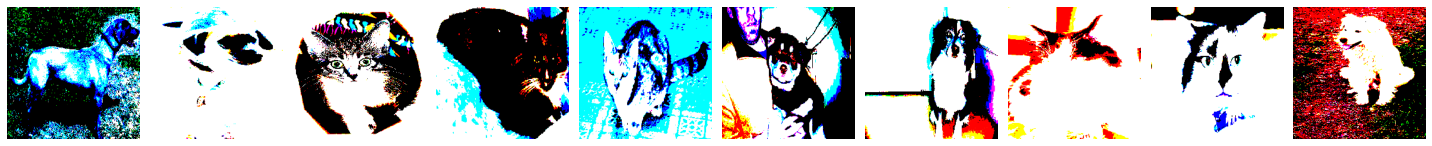

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [17]:
plotImages(imgs)
print(labels)

# coloured data is distorted due to the pre-processing method we applied

# as Labels, we have one-hot encoded vectors , a [1,0] : cat' and '[0,1] : dog'

# Build and Train a CNN

We will be using a Keras CNN model.

1st Layer : kernel size 32 is arbitary, kernel_size 3x3 is very common choice for image data, we specify padding = 'same' i.e, 0 padding

2nd Layers : pool size = 2x2, and strides = 2 --> to cut image dimensions to half

Generally increasing the number of filters with adding layers is a common practice.

In [18]:
model = Sequential([
                   Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', padding = 'same', input_shape=(224,224,3)),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Flatten(), # flattening everything to a 1D tensor
                    Dense(units=2, activation='softmax'),
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

# if we use 'binary_crossentropy' we would have one-ouput node instead of 2

In [21]:
model.fit(x=train_batches, validation_data=valid_batches,epochs=10,verbose=1)

# not specifying y or labels here because the generator has them itself

Epoch 1/10
1800/1800 [==============================] - 52s 26ms/step - loss: 7.5377 - accuracy: 0.6276 - val_loss: 0.5581 - val_accuracy: 0.7250
Epoch 2/10
1800/1800 [==============================] - 45s 25ms/step - loss: 0.3411 - accuracy: 0.8531 - val_loss: 0.6270 - val_accuracy: 0.7288
Epoch 3/10
1800/1800 [==============================] - 51s 29ms/step - loss: 0.1580 - accuracy: 0.9442 - val_loss: 0.7540 - val_accuracy: 0.7218
Epoch 4/10
1800/1800 [==============================] - 58s 32ms/step - loss: 0.0928 - accuracy: 0.9680 - val_loss: 0.9727 - val_accuracy: 0.7258
Epoch 5/10
1800/1800 [==============================] - 68s 38ms/step - loss: 0.0721 - accuracy: 0.9754 - val_loss: 0.9772 - val_accuracy: 0.7188
Epoch 6/10
1800/1800 [==============================] - 73s 41ms/step - loss: 0.0556 - accuracy: 0.9819 - val_loss: 1.1675 - val_accuracy: 0.7334
Epoch 7/10
1800/1800 [==============================] - 80s 44ms/step - loss: 0.0511 - accuracy: 0.9846 - val_loss: 1.2172 -

# Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

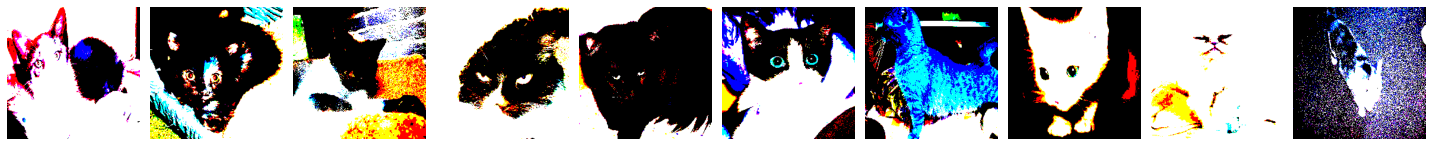

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [22]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [23]:
test_batches.classes # an array that has all of the corresponding labels for each image in the test-set not in one-hot format

array([0, 0, 0, ..., 1, 1, 1])

In [24]:
predictions = model.predict(x=test_batches, verbose=1)

In [25]:
predictions

array([[7.4595845e-01, 2.5404155e-01],
       [9.9994290e-01, 5.7063004e-05],
       [2.0721969e-01, 7.9278028e-01],
       ...,
       [9.9857891e-01, 1.4211182e-03],
       [2.1028677e-06, 9.9999785e-01],
       [6.1231409e-04, 9.9938762e-01]], dtype=float32)

In [26]:
np.round(predictions) # rounded predictions

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [27]:
cm = confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1))

In [28]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap = plt.cm.Blues):
    
    
    """
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    
    """
    
    plt.imshow(cm, interpolation='nearest',cmap=cmap) # defining blue color-maps
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize :
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized Confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max()/ 2.
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
# to check the class indices

test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[702 298]
 [266 734]]


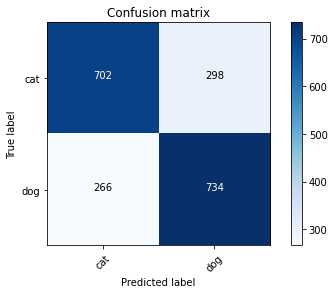

In [29]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title = "Confusion matrix")